In [1]:
# imports
import requests
from datetime import datetime

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.linear_model import LinearRegression, LogisticRegression

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import mean_squared_error, accuracy_score

# set the number display format
pd.set_option('display.float_format', '{:,.5f}'.format)

### Introduction

Two main datasets will be studied: Earth close-approach objects and Earth orbiting objects.

Close-approach objects are those that orbit the sun, so are mostly natural objects that ocasionaly fly past Earth. The second dataset reveals those that are in actual Earth orbit.

The aim is to identify if there are certain links or correlations between the two. Mainly both datasets will be analysed separately and studied to identify further patterns.

Predictions will also be attempted such as future density and how would these objects affect us.

### Data retreival
Using the $SBDB Close-Approach Data API$ we can retreive all the necessary data from the Jet Propulsion Laboratory on Close-approach objects to the Earth by near-Earth objects (NEOs).

Found here:  
https://cneos.jpl.nasa.gov/ca/  
https://ssd-api.jpl.nasa.gov/doc/cad.html

The below code snipped represents a GET request with query parameters for distance and time. We also save the response data to a CSV file with the corresponding fields.

The second dataset can be retreived from the $space-track.org$ website. An overview of the API is found here: https://www.space-track.org/documentation#api-Overview
For these examples however, I will be using the dataset from Kaggle: https://www.kaggle.com/datasets/kandhalkhandeka/satellites-and-debris-in-earths-orbit?resource=download

In [2]:
def get_data (dist_max, date_min, date_max):
    '''Main function to retreive data via API with params and save to CSV'''
    response_data = exec_request (dist_max, date_min, date_max)
    
    # extract fields
    fields = response_data['fields']
    data = response_data['data']

    # convert to DataFrame
    df = pd.DataFrame(data, columns = fields)
    
    # convert to CSV format
    csv_data = df.to_csv(index = False)

    # save the CSV to a file
    df.to_csv('./Datasets/close_approach_data.csv', index = False)

    return df

def get_data_year (dist_max, year):
    '''Retreives data for one year'''

    date_min = f'{year}-01-01'
    date_max = f'{year}-12-31'
    
    response_data = exec_request (dist_max, date_min, date_max)

    # extract fields
    fields = response_data['fields']
    data = response_data['data']

    # convert to DataFrame
    df = pd.DataFrame(data, columns = fields)
    
    # convert to CSV format
    csv_data = df.to_csv(index = False)

    # save the CSV to a file
    df.to_csv('./Datasets/close_approach_data_light.csv', index = False)

    return df

def exec_request (dist_max, date_min, date_max):
    '''GET request and returns data'''
    # define request URL with params
    url = f'https://ssd-api.jpl.nasa.gov/cad.api?dist-max={dist_max}&date-min={date_min}&date-max={date_max}&diameter=true&fullname=true'
    # execute GET request
    response = requests.get(url)
    response_data = response.json()

    return response_data

In [3]:
# get todays date
today = datetime.today().strftime('%Y-%m-%d')
# get data with params
df_main = get_data('0.1au', '2000-01-01', today)
df = get_data_year('0.05', '2023')

### Exploratory Data Analysis
The **_dist_max_** variable is set to 0.1 astronomical units, showing us the objects in that distance. **_date_min_** represents the date from which we want to see objects in our result set. Additionally we retreive the results unit todays date, defined with the **_today_** variable.

The variables in our dataset are the following: 

**des** - Primary designation of the asteroid or comet (e.g., <kbd>443</kbd>, <kbd>2000 SG344</kbd>) 
**orbit_id** - Orbit ID used for the close-approach computation  
**jd** - Time of close-approach (JD Ephemeris Time, TDB)  
**cd** - Time of close-approach (formatted calendar date/time, TDB)  
**dist** - Nominal approach distance (au)  
**dist_min** - Minimum (3-sigma) approach distance (au)  
**dist_max** - Maximum (3-sigma) approach distance (au)  
**v_rel** - Velocity relative to the approach body at close approach (km/s)  
**v_inf** - Velocity relative to a massless body (km/s)  
**t_sigma_f** - 3-sigma uncertainty in the time of close-approach (formatted in days, hours, and minutes; days are not included if zero; example “<kbd>13:02</kbd>” is 13 hours 2 minutes; example “<kbd>2_09:08</kbd>” is 2 days 9 hours 8 minutes)  
**body** - Name of the close-approach body (e.g., <kbd>Earth</kbd>). Only output if the body query parameters is set to <kbd>ALL</kbd>  
**h** - Absolute magnitude H (mag)  
**diameter** - diameter of the body (km). Optional - only output if requested with the <kbd>diameter</kbd> query parameter. <kbd>null</kbd> if not known  
**diameter_sigma** - 1-sigma uncertainty in the diameter of the body (km). Optional - only output if requested with the diameter query parameter. <kbd>null</kbd> if not known  
**fullname** - formatted full-name/designation of the asteroid or comet. 
Optional - only output if requested with the <kbd>fullname</kbd> query parameter. Formatted with leading spaces for column alignment in monospaced font tables 

Perform initial analysis on the dataset.

In [4]:
# read the saved CSV
earth_orbit_objects_data = pd.read_csv('./Datasets/close_approach_data_light.csv')
earth_orbit_objects_data

,des,orbit_id,jd,cd,dist,dist_min,dist_max,v_rel,v_inf,t_sigma_f,h,diameter,diameter_sigma,fullname
0,2022 YS6,6,"2,459,945.55235",2023-Jan-01 01:15,0.01194,0.01191,0.01197,9.71938,9.69640,< 00:01,26.86000,NaN,NaN,(2022 YS6)
1,2022 YR1,8,"2,459,946.36444",2023-Jan-01 20:45,0.04175,0.04136,0.04213,6.03463,6.02404,< 00:01,26.04000,NaN,NaN,(2022 YR1)
2,2022 YT3,8,"2,459,946.52998",2023-Jan-02 00:43,0.02846,0.02838,0.02854,6.43839,6.42384,< 00:01,25.81000,NaN,NaN,(2022 YT3)
3,2022 YU3,5,"2,459,946.71611",2023-Jan-02 05:11,0.02519,0.02502,0.02537,7.13379,7.11894,< 00:01,25.86000,NaN,NaN,(2022 YU3)
4,2022 YY6,4,"2,459,946.96298",2023-Jan-02 11:07,0.00544,0.00541,0.00547,20.26955,20.24537,< 00:01,26.15000,NaN,NaN,(2022 YY6)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1619,2023 YZ,10,"2,460,308.03834",2023-Dec-29 12:55,0.02551,0.02547,0.02554,5.61441,5.59577,< 00:01,25.73000,NaN,NaN,(2023 YZ)
1620,2023 YM,3,"2,460,308.55423",2023-Dec-30 01:18,0.02597,0.02583,0.02611,12.35849,12.35019,00:04,24.92000,NaN,NaN,(2023 YM)
1621,2024 AL3,16,"2,460,308.59918",2023-Dec-30 02:23,0.04322,0.04321,0.04323,11.40930,11.40389,< 00:01,23.70000,NaN,NaN,(2024 AL3)
1622,2024 AE1,5,"2,460,308.73119",2023-Dec-30 05:33,0.01292,0.01292,0.01293,3.50062,3.44122,< 00:01,27.23000,NaN,NaN,(2024 AE1)


In [5]:
earth_orbit_objects_data.describe()

,orbit_id,jd,dist,dist_min,dist_max,v_rel,v_inf,h,diameter,diameter_sigma
count,"1,624.00000","1,624.00000","1,624.00000","1,624.00000","1,624.00000","1,624.00000","1,624.00000","1,624.00000",5.00000,5.00000
mean,6.82635,"2,460,144.67115",0.02126,0.02090,0.02243,10.46355,10.40974,26.14676,0.56820,0.03440
std,15.20095,106.40081,0.01414,0.01400,0.01834,5.07588,5.09354,1.81820,0.74053,0.03075
min,1.00000,"2,459,945.55235",0.00007,0.00007,0.00007,0.43771,0.12547,18.28000,0.10800,0.00200
25%,2.00000,"2,460,049.90100",0.00858,0.00847,0.00862,7.03212,6.98638,25.16000,0.15000,0.00700
50%,4.00000,"2,460,173.48599",0.01983,0.01906,0.02005,9.40847,9.38422,26.22000,0.30700,0.03700
75%,7.00000,"2,460,236.45382",0.03271,0.03223,0.03327,13.22387,13.18860,27.22250,0.40000,0.05000
max,311.00000,"2,460,309.15899",0.04992,0.04974,0.22077,36.37233,36.37067,32.32000,1.87600,0.07600


In [6]:
earth_orbit_objects_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1624 entries, 0 to 1623
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   des             1624 non-null   object 
 1   orbit_id        1624 non-null   int64  
 2   jd              1624 non-null   float64
 3   cd              1624 non-null   object 
 4   dist            1624 non-null   float64
 5   dist_min        1624 non-null   float64
 6   dist_max        1624 non-null   float64
 7   v_rel           1624 non-null   float64
 8   v_inf           1624 non-null   float64
 9   t_sigma_f       1624 non-null   object 
 10  h               1624 non-null   float64
 11  diameter        5 non-null      float64
 12  diameter_sigma  5 non-null      float64
 13  fullname        1624 non-null   object 
dtypes: float64(9), int64(1), object(4)
memory usage: 177.8+ KB


In [7]:
# check for null values
df.isnull().sum()

des                  0
orbit_id             0
jd                   0
cd                   0
dist                 0
dist_min             0
dist_max             0
v_rel                0
v_inf                0
t_sigma_f            0
h                    0
diameter          1619
diameter_sigma    1619
fullname             0
dtype: int64

In [8]:
# check unique value counts
df.nunique()

des               1620
orbit_id            62
jd                1624
cd                1621
dist              1624
dist_min          1624
dist_max          1624
v_rel             1624
v_inf             1624
t_sigma_f          111
h                  645
diameter             5
diameter_sigma       5
fullname          1620
dtype: int64

##### Update column types:

In [9]:
def update_dataset (df):
    '''Performs multiple updates and cleanup. Returns new dataframe with approach time and velocity.'''
    # copy initial data to a new instance
    objects_data = df.copy()
    # update close approach time column to datetime format
    objects_data['cd'] = pd.to_datetime(objects_data['cd'], format = '%Y-%b-%d %H:%M')
    
    # update dist_min and dist_max columns to int
    objects_data['dist_min'] = pd.to_numeric(objects_data['dist_min'])
    objects_data['dist_max'] = pd.to_numeric(objects_data['dist_max'])
    objects_data['v_rel'] = pd.to_numeric(objects_data['v_rel'])
    
    values = objects_data.loc[
            :,
            ['cd', 'dist_min', 'dist_max', 'v_rel']
        ].rename(
        columns = {'cd': 'close_approach_time', 'v_rel': 'velocity'}
    )

    return values

In [10]:
def remove_objects (df):
    '''Returns columns with int and float. Excludes object type columns.'''
    # Drop columns with NaN values
    data = df.dropna(axis=1)
    
    # Exclude object types
    values = data.select_dtypes(exclude=[np.object_])

    return values

In [11]:
values = update_dataset(df)

In [12]:
values_main = update_dataset(df_main)

##### Analysis of coorelation between features.

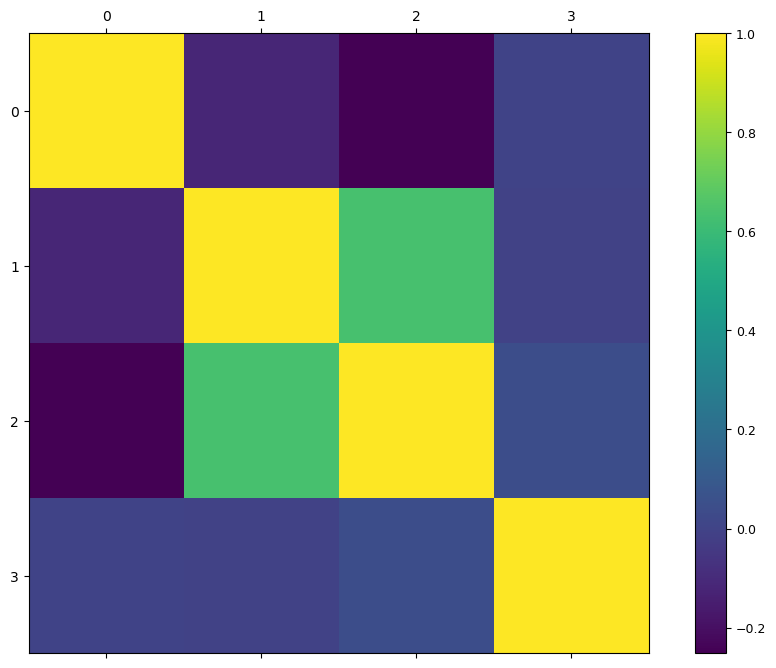

In [13]:
f = plt.figure(figsize=(12, 8))
plt.matshow(values_main.corr(), fignum=f.number)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=9)

<Axes: >

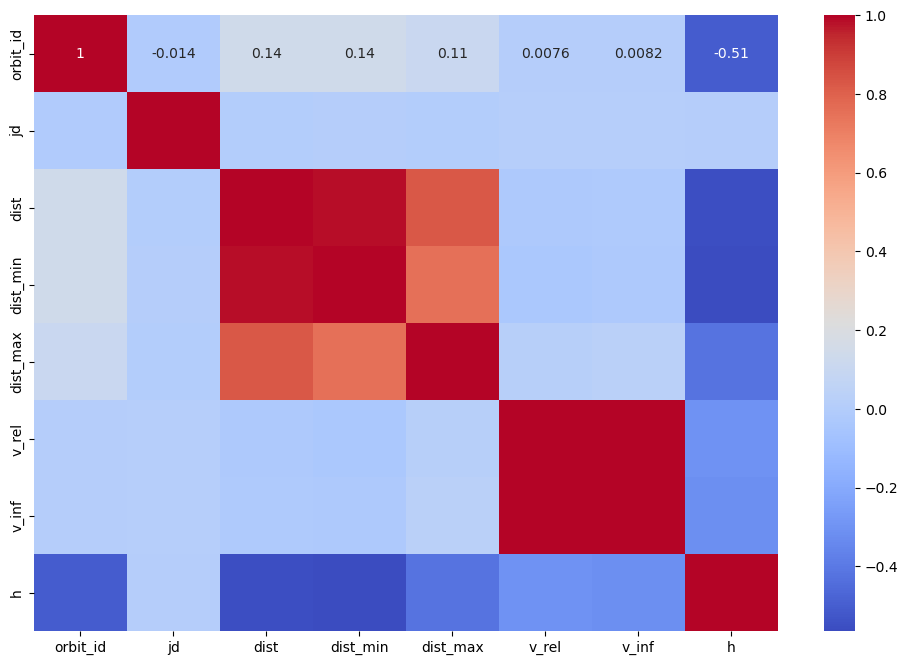

In [14]:
# correlation matrix
df_clean = remove_objects(earth_orbit_objects_data)
plt.figure(figsize=(12,8))
sns.heatmap(df_clean.corr(), annot=True, cmap='coolwarm')

In [15]:
earth_orbit_objects_data.dist.describe()

count   1,624.00000
mean        0.02126
std         0.01414
min         0.00007
25%         0.00858
50%         0.01983
75%         0.03271
max         0.04992
Name: dist, dtype: float64

##### Review frequency of objects at different distnaces.

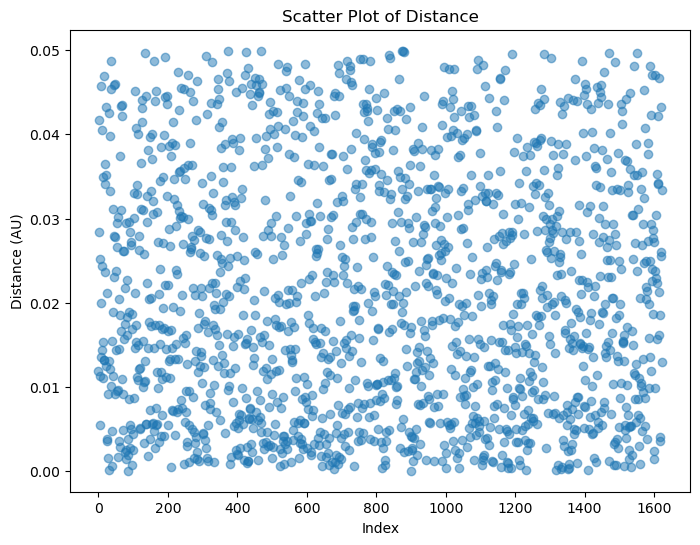

In [16]:
plt.figure(figsize = (8, 6))
plt.scatter(range(len(earth_orbit_objects_data)), earth_orbit_objects_data['dist'], alpha = 0.5)
plt.xlabel('Index')
plt.ylabel('Distance (AU)')
plt.title('Scatter Plot of Distance')
plt.show()

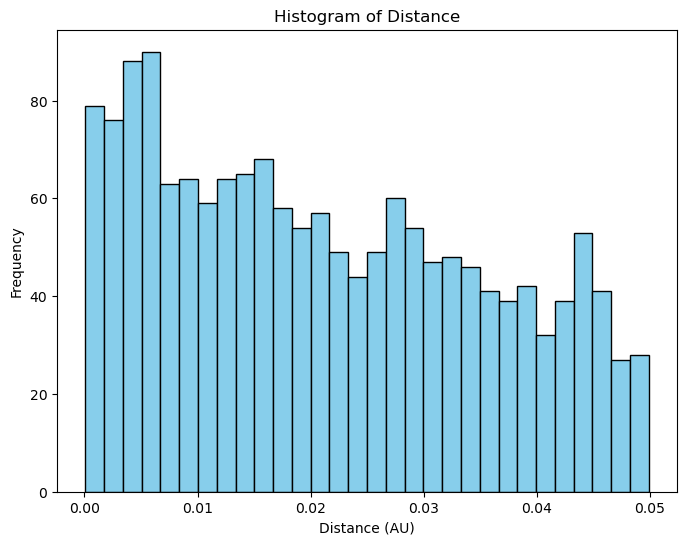

In [17]:
plt.figure(figsize = (8, 6))
plt.hist(earth_orbit_objects_data['dist'], bins=30, color='skyblue', edgecolor='black')
plt.xlabel('Distance (AU)')
plt.ylabel('Frequency')
plt.title('Histogram of Distance')
plt.show()

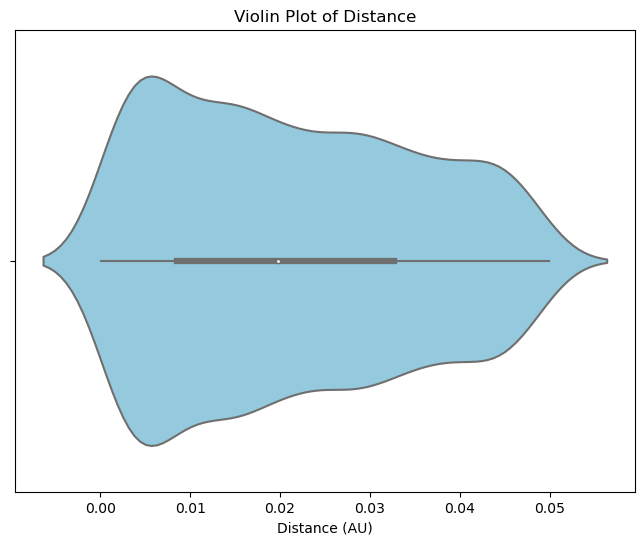

In [18]:
plt.figure(figsize = (8, 6))
sns.violinplot(x = earth_orbit_objects_data['dist'], color = 'skyblue')
plt.xlabel('Distance (AU)')
plt.title('Violin Plot of Distance')
plt.show()

0.00 distance seems incorrect however the minumum distance is 0.00007. It seems that we have more objects at a closer distance.

Below we identify how the velocity of objects has changed over time.

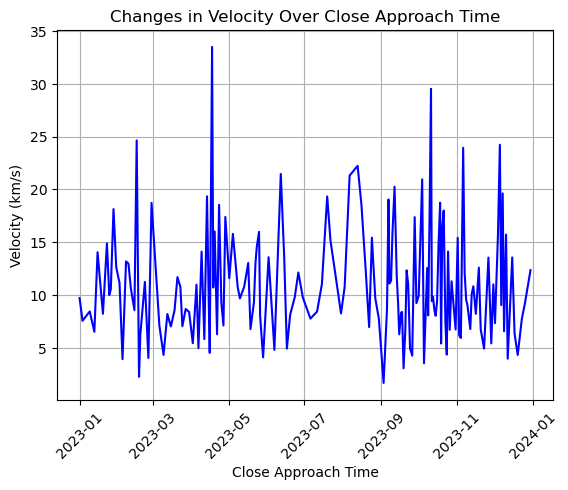

In [19]:
def plot_yearly_velocity (values, downsample):
    '''Plot velocity for early approaches. Downsample data if dataset is large.'''
    # downsample the data by taking every nth point (e.g., every 10th point)
    sampled_values = values.iloc[::downsample, :]
    
    # sort velocity
    sampled_values.sort_values(by = 'velocity')
    
    # plot data
    plt.plot(sampled_values['close_approach_time'], sampled_values['velocity'], linestyle='-', color='b')
    
    plt.xlabel('Close Approach Time')
    plt.ylabel('Velocity (km/s)')
    plt.title('Changes in Velocity Over Close Approach Time')
    plt.xticks(rotation=45)  # rotate x-axis labels for better readability
    plt.grid(True)  # add a grid for better readability

plot_yearly_velocity(values, 10)

In [20]:
# get data for multiple years (runs API request)
df_89 = get_data_year('0.05', '1989')
df_90 = get_data_year('0.05', '1990')
df_91 = get_data_year('0.05', '1991')

In [21]:
values_89 = update_dataset(df_89)
values_90 = update_dataset(df_90)
values_91 = update_dataset(df_91)

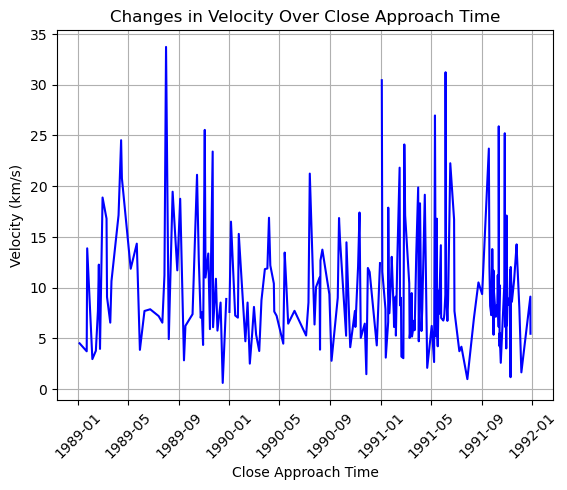

In [22]:
plot_yearly_velocity(values_89, 2)
plot_yearly_velocity(values_90, 2)
plot_yearly_velocity(values_91, 1)

In [23]:
# take a larger dataframe
df_range_05 = get_data('0.05au', '2000-01-01', today)

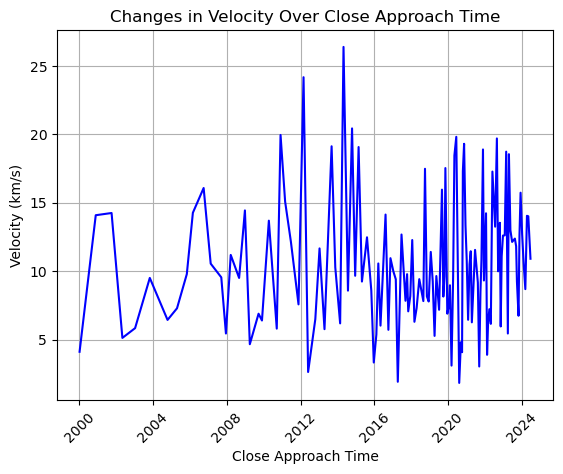

In [24]:
values_range_05 = update_dataset(df_range_05)
plot_yearly_velocity(values_range_05, 120)

In [25]:
# increase distance
df_range_2 = get_data('0.2', '2000-01-01', today)

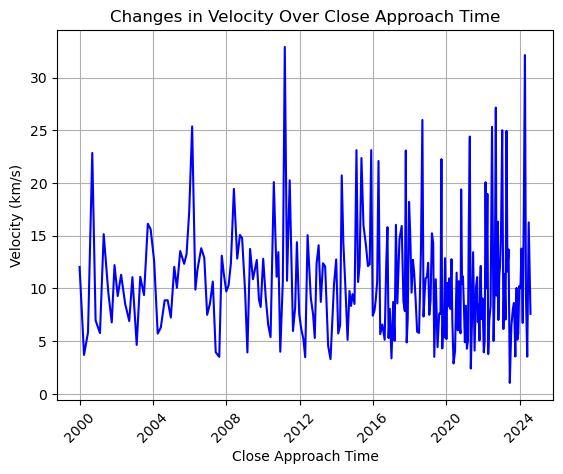

In [26]:
values_range_2 = update_dataset(df_range_2)
plot_yearly_velocity(values_range_2, 200)

In [27]:
# lower distance - increase years
df_range_1_y = get_data('0.1', '1980-01-01', today)

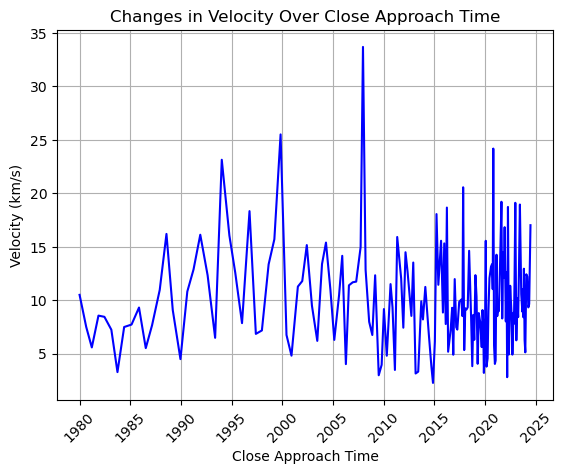

In [28]:
values_range_1_y = update_dataset(df_range_1_y)
plot_yearly_velocity(values_range_1_y, 200)

##### Investigating the two pairs magnitude - velocity and magnitude - distance.

In [29]:
def update_dataset_m_v (df):
    '''Performs multiple updates and cleanup. Returns new dataframe with magnitude and velocity.'''
    # copy initial data to a new instance
    objects_data = df.copy()
    
    # update dist_min and dist_max columns to int
    objects_data['h'] = pd.to_numeric(objects_data['h'])
    objects_data['v_rel'] = pd.to_numeric(objects_data['v_rel'])
    
    values = objects_data.loc[
            :,
            ['h', 'v_rel']
        ].rename(
        columns = {'h': 'magnitude', 'v_rel': 'velocity'}
    )

    return values

In [30]:
magnitude_velocity_data = update_dataset_m_v(df_main)
magnitude_velocity_data

,magnitude,velocity
0,24.91000,4.10991
1,24.80000,13.23488
2,27.70000,8.90828
3,26.00000,9.91327
4,25.30000,5.56508
...,...,...
27518,25.60000,4.78321
27519,24.83800,14.19475
27520,24.91700,8.61043
27521,25.13300,5.72461


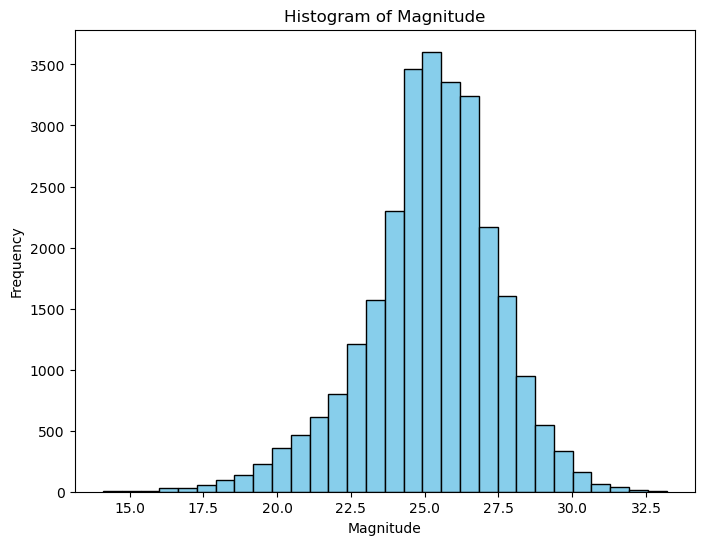

In [31]:
plt.figure(figsize = (8, 6))
plt.hist(magnitude_velocity_data['magnitude'], bins=30, color='skyblue', edgecolor='black')
plt.xlabel('Magnitude')
plt.ylabel('Frequency')
plt.title('Histogram of Magnitude')
plt.show()

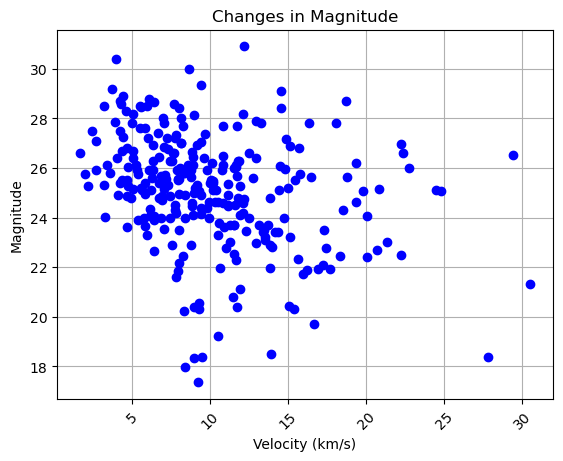

In [32]:
sampled_values_m_v = magnitude_velocity_data.iloc[::100, :]
plt.plot(sampled_values_m_v['velocity'], sampled_values_m_v['magnitude'], linestyle=' ', color='b', marker='o')
    
plt.xlabel('Velocity (km/s)')
plt.ylabel('Magnitude')
plt.title('Changes in Magnitude')
plt.xticks(rotation=45)  # rotate x-axis labels for better readability
plt.grid(True)  # add a grid for better readability

In [33]:
def update_dataset_m_d (df):
    '''Performs multiple updates and cleanup. Retruns new dataframe with magnitude and distance.'''
    # copy initial data to a new instance
    objects_data = df.copy()
    
    # update dist_min and dist_max columns to int
    objects_data['h'] = pd.to_numeric(objects_data['h'])
    objects_data['dist'] = pd.to_numeric(objects_data['dist'])
    
    values = objects_data.loc[
            :,
            ['h', 'dist']
        ].rename(
        columns = {'h': 'magnitude', 'dist': 'distance'}
    )

    return values

In [34]:
magnitude_distance_data = update_dataset_m_d(df_main)
magnitude_distance_data[['magnitude', 'distance']].corr()

,magnitude,distance
magnitude,1.00000,-0.44333
distance,-0.44333,1.00000


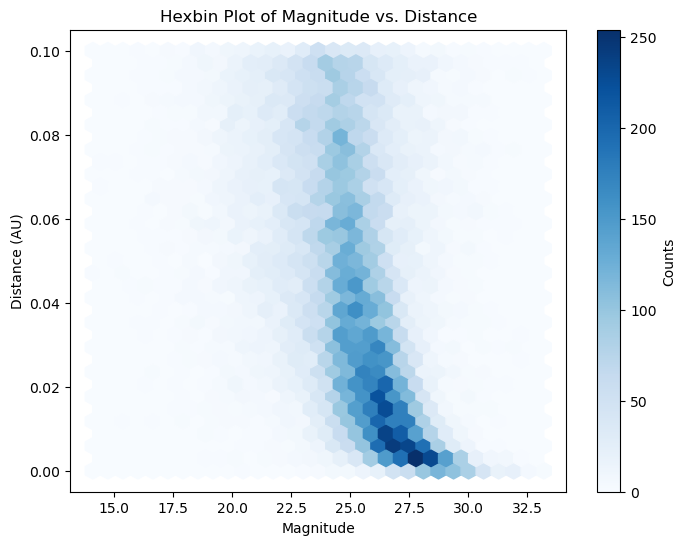

In [35]:
plt.figure(figsize=(8, 6))
plt.hexbin(magnitude_distance_data['magnitude'], magnitude_distance_data['distance'], gridsize=30, cmap='Blues')
plt.colorbar(label='Counts')
plt.xlabel('Magnitude')
plt.ylabel('Distance (AU)')
plt.title('Hexbin Plot of Magnitude vs. Distance')
plt.show()

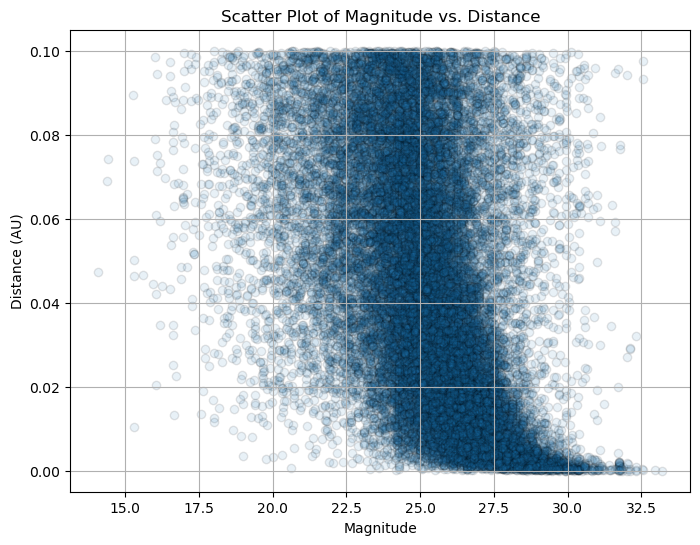

In [36]:
plt.figure(figsize=(8, 6))
plt.scatter(magnitude_distance_data['magnitude'], magnitude_distance_data['distance'], alpha=0.1, edgecolor='k')
plt.xlabel('Magnitude')
plt.ylabel('Distance (AU)')
plt.title('Scatter Plot of Magnitude vs. Distance')
plt.grid(True)
plt.show()

### Analysis on direct Earth satelites.
#### Here we take our second dataset.

In [37]:
# get the data from space track
earth_close_orbit_data = pd.read_csv('./Datasets/space_decay.csv')
earth_close_orbit_data

,CCSDS_OMM_VERS,COMMENT,CREATION_DATE,ORIGINATOR,OBJECT_NAME,OBJECT_ID,CENTER_NAME,REF_FRAME,TIME_SYSTEM,MEAN_ELEMENT_THEORY,...,RCS_SIZE,COUNTRY_CODE,LAUNCH_DATE,SITE,DECAY_DATE,FILE,GP_ID,TLE_LINE0,TLE_LINE1,TLE_LINE2
0,2,GENERATED VIA SPACE-TRACK.ORG API,2021-11-01T06:46:11,18 SPCS,ARIANE 42P+ DEB,1992-072J,EARTH,TEME,UTC,SGP4,...,MEDIUM,FR,"1,992.00000",FRGUI,NaN,3195178,188614016,0 ARIANE 42P+ DEB,1 26741U 92072J 21304.94919376 .00000883 0...,2 26741 7.7156 90.2410 6528926 243.1216 38...
1,2,GENERATED VIA SPACE-TRACK.ORG API,2021-11-01T04:58:37,18 SPCS,SL-8 DEB,1979-028C,EARTH,TEME,UTC,SGP4,...,SMALL,CIS,"1,979.00000",PKMTR,NaN,3194950,188593285,0 SL-8 DEB,1 26743U 79028C 21304.68908982 .00000079 0...,2 26743 82.9193 299.1120 0030720 158.9093 201...
2,2,GENERATED VIA SPACE-TRACK.ORG API,2021-11-01T06:26:11,18 SPCS,GSAT 1,2001-015A,EARTH,TEME,UTC,SGP4,...,LARGE,IND,"2,001.00000",SRI,NaN,3195026,188609573,0 GSAT 1,1 26745U 01015A 21305.22411368 -.00000165 0...,2 26745 12.1717 16.5368 0237386 250.1248 146...
3,2,GENERATED VIA SPACE-TRACK.ORG API,2021-10-31T18:07:15,18 SPCS,CZ-4 DEB,1999-057MB,EARTH,TEME,UTC,SGP4,...,SMALL,PRC,"1,999.00000",TSC,NaN,3194431,188556894,0 CZ-4 DEB,1 26754U 99057MB 21304.46625230 .00002265 0...,2 26754 98.4781 8.7205 0060618 37.3771 323...
4,2,GENERATED VIA SPACE-TRACK.ORG API,2021-11-01T04:58:37,18 SPCS,CZ-4 DEB,1999-057MC,EARTH,TEME,UTC,SGP4,...,SMALL,PRC,"1,999.00000",TSC,NaN,3194950,188592541,0 CZ-4 DEB,1 26755U 99057MC 21304.74081807 .00002610 0...,2 26755 98.4232 122.0724 0062255 345.1605 27...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14367,2,GENERATED VIA SPACE-TRACK.ORG API,2021-10-29T18:22:04,18 SPCS,TBA - TO BE ASSIGNED,NaN,EARTH,TEME,UTC,SGP4,...,NaN,NaN,NaN,NaN,NaN,3191411,188414015,0 TBA - TO BE ASSIGNED,1 87970U 21285.56271139 +.00354808 +0...,2 87970 99.0098 214.6827 0011899 219.1613 140...
14368,2,GENERATED VIA SPACE-TRACK.ORG API,2021-10-31T18:06:35,18 SPCS,TBA - TO BE ASSIGNED,NaN,EARTH,TEME,UTC,SGP4,...,NaN,NaN,NaN,NaN,NaN,3194430,188550573,0 TBA - TO BE ASSIGNED,1 89171U 21304.27943186 +.00020950 +0...,2 89171 99.0272 141.1159 0055597 76.8926 283...
14369,2,GENERATED VIA SPACE-TRACK.ORG API,2021-10-31T18:07:15,18 SPCS,TBA - TO BE ASSIGNED,NaN,EARTH,TEME,UTC,SGP4,...,NaN,NaN,NaN,NaN,NaN,3194431,188561362,0 TBA - TO BE ASSIGNED,1 T0007U 21304.15669309 -.00000068 0...,2 T0007 31.9916 262.9339 0566728 162.7824 199...
14370,2,GENERATED VIA SPACE-TRACK.ORG API,2021-10-31T18:07:15,18 SPCS,TBA - TO BE ASSIGNED,NaN,EARTH,TEME,UTC,SGP4,...,NaN,NaN,NaN,NaN,NaN,3194431,188561387,0 TBA - TO BE ASSIGNED,1 T0207U 21304.37554955 .00000690 0...,2 T0207 98.6758 348.3068 0058220 187.0288 173...


Columns and information for this dataset:

**Apogee**  
Point in the orbit where an Earth satellite is farthest from the Earth. Units are kilometers.  

**Argument of Perigee (Degrees)**  
The angle between the ascending node and the orbit's point of closest approach to the earth (perigee).  

**B*** **Drag Term**  
Also called the radiation pressure coefficient. Units are earth radii^-1. The last two characters define an applicable power of 10. 

**Catalog Change Report**  
Report that details the changes (launches, additions, decays and updates) to the satellite catalog (SATCAT). Now parts 4 & 5 of the SSR

**Catalog Number**  
Sequential number assigned by the US Space Force as objects are cataloged. Synonyms: Satellite Catalog Number, NORAD_CAT_ID, and OBJECT_NUMBER.

**Celestial Equator**  
It is a projection of the terrestrial equator out into space.

**Checksum**  
Sum of all of the characters in the data line, modulo 10.  

**Common Name**  
Also known as OBJECT_NAME, this is simply the name associated with the satellite.  

**Conjunction Assessment (CA)**  
The process of predicting and reporting the close approaches between Resident Space Object (RSOs) or between launch vehicles and RSOs.  

**Conjunction Data Message (CDM)**  
CCSDS Recommended Standard message format for exchanging spacecraft conjunction information between originators of Conjunction Assessments (CAs) and satellite owner/operators and other authorized parties.

**Country**  
The nation or group that has responsibility for an object  

**Debris**  
Any object with the string 'DEB' or 'COOLANT' or 'SHROUD' or 'WESTFORD NEEDLES' in the SATCAT object common name.  

**Decay**  
The lessening of the eccentricity of the elliptical orbit of an artificial satellite.  

**Decay Date**
Date object reentered the earth's atmosphere in YYYY-MM-DD format.  

**Decay Message Types**  
SATCAT - Historical.  
Decay Entry - Historical.  
TIP Message - Prediction.  
60day Decay - Prediction.  

**Eccentricity**  
A constant defining the shape of the orbit (0=circular, Less than 1=elliptical).

**Element Number**  
The ELSET number is a running count of all ELSETs generated by 18 SDS for this object.  

**Element Set (ELSET)**  
See: Two Line Element set.  

**Element Set Epoch**  
The first two digits ('13') indicate the year. Add 1900 for years >= 57, and 2000 for all others. The remainder of the field ('236.56031392') is the Julian day of the year.

**Epoch**  
The specific time at which the position of a satellite is defined.

**File**  
The unique identifying number of the source file for a particular object's data - higher numbers are more recent uploads.

**First Derivative of the Mean Motion**  
Is the daily rate of change in the number of revolutions the object completes each day, divided by 2. Units are revolutions/day.

**Geosynchronous Report**  
Report generated using search parameters of satellite period between 1430-1450 minutes.

**Inclination - Orbital Inclination (Degrees)**  
The angle between the equator and the orbit plane.

**INTLDES - International Designator**  
Also known as COSPAR designation or NSSDC ID, this is one format for uniquely identifying an object.

**Latest Data**  
Displays the latest ELSET for the object.

**Latest ELSET**  
Displays the last 5 ELSETs for the object.

**Launch Date**  
Date object was launched in YYYY-MM-DD format.  

**Launch Number**  
A three-letter code representing the sequential identifier of a piece in a launch.  

**Launch Site**  
See: https://www.space-track.org/basicspacedata/query/class/launch_site/format/html  

**Laser Clearinghouse (LCH)**  
An organization within S4S that supports safe and responsible laser activities consistent with the needs of national defense.  

**Mean Anomaly (degrees)**  
The angle, measured from perigee, of the satellite location in the orbit referenced to a circular orbit with radius equal to the semi-major axis.  

**Mean Equinox**  
The direction to the equinox at a particular epoch, with the effect of nutation subtracted.  

**Message Epoch**  
The UTC time that 18 SDS generated a message.  

**New Registered User Application**  
On-line application submitted in order to obtain a user account on Space-Track.org  

**Object ID**  
The CCSDS's name for International Designator.  

**Object Number - Catalog Number**  
Synonyms: Satellite Catalog Number, NORAD_CAT_ID, Object Number  

**Orbit Mean-Elements Message (OMM)**  
An approved international standard for a mathematical representation of a satellite’s mean orbit IAW CCSDS 502.0-B-2 Orbit Data Messages Blue Book.

**Orbital Data Request (ODR)**  
The ODR is the form submitted by requesters asking for SSA services or information.  

**Orbital Data Request Process**  
The procedures used by Space-Track.org users to request Space Situational Awareness (SSA) advanced services support.

**Orbit Inclination (Degrees)**  
The angle between the equator and the orbit plane.  

**Owner/Operator (O/O)**  
The designated control center or agency that is the focal point for operational control of a satellite payload, and/or vehicle, and/or ground site. The owner/operator interfaces with USSPACECOM and/or S4S and is generally the location where the operations center is located for a given space system.  

**Payload**  
Any object not classified in the SATCAT as a rocket body or debris is considered a payload.  

**Perigee**  
Point in the orbit where an Earth satellite is closest to the Earth. Units are kilometers.  

**Period**  
The number of minutes an object takes to make one full orbit.  

**Precedence**  
In the Decay class, lower PRECEDENCE values indicate more recent data.  

**Predicted Decay Location**  
In the TIP class, LAT / LON values show the location above which an object is predicted to arrive at 10km altitude during its descent, not the predicted Earth impact location.  

**Predicted Decay Time**  
The time that an object is predicted to reach its decay location. Format: GMT Date (YYYY-MM-DD, HH:MM:SS) +/- XX Hours.  

**Radar Cross Section (RCS)**  
A measure of how detectable an object is by radar, measured in square meters. We do not provide numeric RCS values unless you have a valid requirement to see them. If you have a requirement for these values, please submit an Orbital Data Request (ODR) to get permission for RCS values. See our help page at https://www.space-track.org//documentation#/odr  

**Recent Satellite Decays**  
A listing of recent satellite decays on Space-Track.org.  

**Revolution Number at Epoch**  
The number of orbits the object has completed at Epoch Time.  

**Right Ascension (or Longitude) of Ascending Node (degrees)**  
Is the angle of the ascending node measured EAST of the vernal equinox along the celestial equator.  

**Rocket Body**  
The propulsion unit(s) used to deploy satellites into orbit. These are cataloged differently from standard debris because they can have mechanisms or fuel on board that can affect the orbital behavior of the rocket body even after long periods of time. Rocket bodies are also constructed to endure high temperatures and stresses associated with launch so they have a greater probability of surviving reentry and require closer attention than most debris. Rocket Bodies are any object which contains the strings 'R/B' or 'AKM' (Apogee Kick Motor) or 'PKM' (Perigee Kick Motor) but not 'DEB' (Debris) in the SATCAT object common name.  

**S4S - CJFSCC**  
The Space Forces - Space is the Space Force Service component to United States Space Command and is responsible for executing continuous, integrated space operations to deliver theater and global effects in support of national and combatant commander objectives. Additionally, the S4S commander conducts joint space operations on behalf of USSPACECOM commander through Combined Joint Force Space Component Commander (CJFSCC) authorities.  

**Satellite**  
Any object in orbit around the Earth. Used interchangeably with 'resident space object'. However, commonly and mistakenly used to mean payload. Both a piece of debris and the moon are satellites.(SI 534-03)  

**Satellite Box Score**  
Accounting of man-made objects that have been or are in orbit by country. (SI 534-03)  

**Satellite Catalog Number**  
Sequential number assigned by the US Space Force as objects are cataloged. Synonyms: Catalog Number, NORAD_CAT_ID, and OBJECT_NUMBER.  

**Satellite Catalog (SATCAT)**  
A catalog of satellite positional data maintained by 18 SDS.(SI 534-03  

**Satellite Situation Report**  
Listing of those satellites (objects) currently in orbit and those which have previously orbited the Earth. Some objects are too small or too far from the Earth's surface to be detected; therefore, the Satellite Situation Report does not include all man-made objects orbiting the Earth.  

**Second Derivative of the Mean Motion**  
Measures the second time derivative in daily mean motion.  

**Space**  
The area above the lowest altitude that permits a vehicle to orbit the Earth without entering the earth's atmosphere. That altitude is approximately 100 kilometers (62 miles).  

**Space Surveillance Data**  
Data derived from the observation of space and activities occurring in space.  

**Space Weather**  
The conditions and phenomena in space and specifically in the near-Earth environment that may affect space assets or space operations.  

**SI 534-03**  
USSTRATCOM Strategic Instruction (SI) 534-03, Sharing Space Situational Awareness (SSA) Information, 18 January 2013. Establishes standard guidance for providing unclassified SSA information to United States Government (USG) agencies (including organizations supporting the USG under contract) and non-USG entities.  

**Tracking and Impact Prediction (TIP) Message**  
Projected satellite reentry predictions for objects which have the potential for generating debris which could pose a hazard to people or property on Earth.  

**Two Line Element set (TLE)**  
A mathematical representation of a satellite’s mean orbit.  

**Three Line Format**  
Same as a TLE except the first line contains the satellite common name.  

**Vernal Equinox**  
The point on the celestial sphere at which the Sun passes from south to north of the celestial equator each year.

Relevant acronyms in this dataset include:  
**AKM** -	Apogee Kick Motor  
**DD** -	Day  
**DEB** -	Debris  
**DoD** -	Department of Defense  
**ELSET** -	Element Set  
**GMT** -	Greenwich Mean Time  
**HH**:	Hour  
**S4S** -	Space Forces - Space  
**MM** -	Month or Minutes  
**PKM** -	Perigee Kick Motor  
**RCS** -	Radar Cross Section  
**SATCAT** -	Satellite Catalog  
**SS** -	Seconds  
**SSA** -	Space Situational Awareness  
**TBA** -	"To Be Announced" in the future.  
**TBD** -	"To Be Determined" or unknown  
**TIP** -	Tracking and Impact Prediction  
**TLE** -	Two Line Element set  
**USG** -	United States Government  
**USSTRATCOM** -	United States Strategic Command  
**USSPACECOM** -	United States Space Command  
**YYYY** -	Year  

In [38]:
earth_close_orbit_data.describe()

,CCSDS_OMM_VERS,MEAN_MOTION,ECCENTRICITY,INCLINATION,RA_OF_ASC_NODE,ARG_OF_PERICENTER,MEAN_ANOMALY,EPHEMERIS_TYPE,NORAD_CAT_ID,ELEMENT_SET_NO,...,MEAN_MOTION_DOT,MEAN_MOTION_DDOT,SEMIMAJOR_AXIS,PERIOD,APOAPSIS,PERIAPSIS,LAUNCH_DATE,DECAY_DATE,FILE,GP_ID
count,"14,372.00000","14,372.00000","14,372.00000","14,372.00000","14,372.00000","14,372.00000","14,372.00000","14,372.00000","14,372.00000","14,372.00000",...,"14,372.00000","14,372.00000","14,372.00000","14,372.00000","14,372.00000","14,372.00000","14,333.00000",0.00000,"14,372.00000","14,372.00000"
mean,2.00000,12.46385,0.06717,74.35421,182.35311,165.97720,191.01560,0.00000,"39,558.16038",999.00000,...,0.00005,0.00000,"10,636.18521",223.52156,"5,721.06018","2,795.04025","2,004.50757",NaN,"3,194,186.13262","188,563,823.26343"
std,0.00000,4.50930,0.18155,29.62678,116.71771,104.46187,109.87381,0.00000,"7,619.84613",0.00000,...,0.00239,0.00001,"9,580.62723",446.51704,"13,016.29901","7,943.04526",13.56523,NaN,"3,119.11706","139,361.55419"
min,2.00000,0.05178,0.00000,0.00140,0.02000,0.00820,0.00480,0.00000,"26,741.00000",999.00000,...,-0.01487,-0.00004,"6,542.85000",87.78300,183.39300,73.27900,"1,961.00000",NaN,"3,142,499.00000","186,092,637.00000"
25%,2.00000,13.45214,0.00073,53.05530,71.98735,77.36347,90.00160,0.00000,"33,965.75000",999.00000,...,0.00000,0.00000,"6,956.24675",96.23275,599.87600,546.11500,"1,997.00000",NaN,"3,194,431.00000","188,566,486.50000"
50%,2.00000,14.27705,0.00342,86.36920,189.46025,150.48390,206.95740,0.00000,"40,165.50000",999.00000,...,0.00001,0.00000,"7,177.54900",100.86100,843.68600,702.43350,"2,002.00000",NaN,"3,194,950.00000","188,598,562.50000"
75%,2.00000,14.96374,0.01351,98.56512,292.48475,258.32855,284.16320,0.00000,"45,173.50000",999.00000,...,0.00003,0.00000,"7,468.05500",107.04600,"1,207.91950",831.95975,"2,018.00000",NaN,"3,195,064.00000","188,610,661.75000"
max,2.00000,16.40410,0.89722,144.58620,359.96790,359.98990,359.98190,0.00000,"270,288.00000",999.00000,...,0.22532,0.00165,"304,049.63500","27,808.42900","372,136.40200","224,547.01500","2,021.00000",NaN,"3,195,727.00000","188,625,007.00000"


### Exploratory Data Analysis

Perform observation on the mean motion which is the daily rate of change in the number of revolutions the object completes each day, divided by 2. Units are revolutions/day. Add the object type and size to see how they compare. Additional observations are done on which country performed the launch and when was the launch performed.

In [39]:
earth_close_orbit_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14372 entries, 0 to 14371
Data columns (total 40 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   CCSDS_OMM_VERS       14372 non-null  int64  
 1   COMMENT              14372 non-null  object 
 2   CREATION_DATE        14372 non-null  object 
 3   ORIGINATOR           14372 non-null  object 
 4   OBJECT_NAME          14372 non-null  object 
 5   OBJECT_ID            14333 non-null  object 
 6   CENTER_NAME          14372 non-null  object 
 7   REF_FRAME            14372 non-null  object 
 8   TIME_SYSTEM          14372 non-null  object 
 9   MEAN_ELEMENT_THEORY  14372 non-null  object 
 10  EPOCH                14372 non-null  object 
 11  MEAN_MOTION          14372 non-null  float64
 12  ECCENTRICITY         14372 non-null  float64
 13  INCLINATION          14372 non-null  float64
 14  RA_OF_ASC_NODE       14372 non-null  float64
 15  ARG_OF_PERICENTER    14372 non-null 

In [40]:
earth_close_orbit_data.MEAN_MOTION

0        2.92170
1       13.75497
2        1.03822
3       14.77591
4       14.72448
          ...   
14367   15.46578
14368   14.96756
14369   12.90969
14370   14.24532
14371   12.95157
Name: MEAN_MOTION, Length: 14372, dtype: float64

In [41]:
earth_close_orbit_data.OBJECT_TYPE

0         DEBRIS
1         DEBRIS
2        PAYLOAD
3         DEBRIS
4         DEBRIS
          ...   
14367        TBA
14368        TBA
14369        TBA
14370        TBA
14371        TBA
Name: OBJECT_TYPE, Length: 14372, dtype: object

In [42]:
earth_close_orbit_data.RCS_SIZE

0        MEDIUM
1         SMALL
2         LARGE
3         SMALL
4         SMALL
          ...  
14367       NaN
14368       NaN
14369       NaN
14370       NaN
14371       NaN
Name: RCS_SIZE, Length: 14372, dtype: object

##### Plot the correlation between features:

<Axes: >

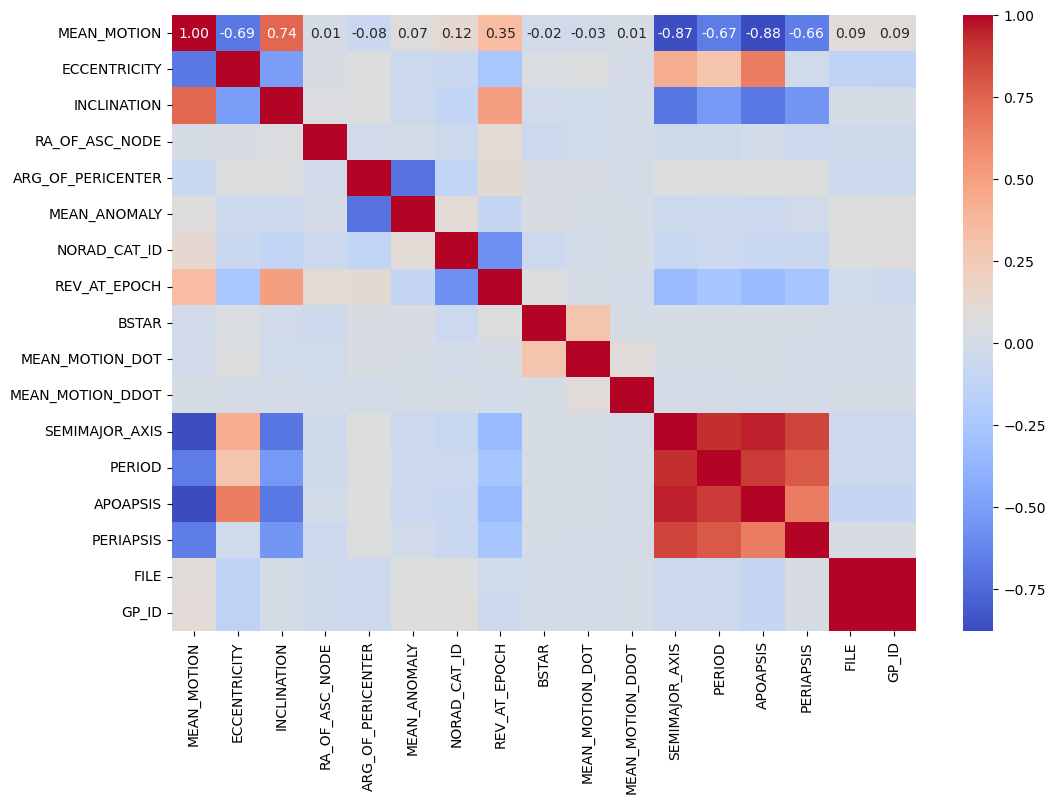

In [43]:
# correlation matrix
# remove object types and NaN values
earth_close_orbit_data_clean = remove_objects(earth_close_orbit_data)
# remove constant values
constant_columns = earth_close_orbit_data_clean.loc[:, earth_close_orbit_data_clean.nunique() == 1]
earth_close_orbit_data_clean = earth_close_orbit_data_clean.drop(columns=constant_columns)

plt.figure(figsize=(12,8))
sns.heatmap(earth_close_orbit_data_clean.corr(), annot=True, fmt=".2f", cmap='coolwarm')

In [44]:
earth_close_orbit_data_clean.corr()

,MEAN_MOTION,ECCENTRICITY,INCLINATION,RA_OF_ASC_NODE,ARG_OF_PERICENTER,MEAN_ANOMALY,NORAD_CAT_ID,REV_AT_EPOCH,BSTAR,MEAN_MOTION_DOT,MEAN_MOTION_DDOT,SEMIMAJOR_AXIS,PERIOD,APOAPSIS,PERIAPSIS,FILE,GP_ID
MEAN_MOTION,1.00000,-0.68696,0.73617,0.00729,-0.07637,0.06785,0.11958,0.34896,-0.02407,-0.02533,0.01055,-0.87137,-0.66851,-0.87934,-0.66105,0.08881,0.09236
ECCENTRICITY,-0.68696,1.00000,-0.51144,0.02378,0.04665,-0.06177,-0.07066,-0.24984,0.03343,0.04752,-0.00390,0.43043,0.29733,0.65366,-0.03283,-0.13485,-0.13815
INCLINATION,0.73617,-0.51144,1.00000,0.04202,0.04742,-0.05086,-0.11287,0.50611,-0.02209,-0.03218,-0.01277,-0.69062,-0.53275,-0.68522,-0.54314,0.00757,0.00296
RA_OF_ASC_NODE,0.00729,0.02378,0.04202,1.00000,-0.02051,-0.00099,-0.05234,0.09774,-0.05330,-0.03046,-0.01435,-0.03667,-0.03590,-0.01958,-0.05637,-0.03565,-0.03631
ARG_OF_PERICENTER,-0.07637,0.04665,0.04742,-0.02051,1.00000,-0.71042,-0.11356,0.10669,0.02575,0.02148,-0.00888,0.05976,0.04636,0.05731,0.05024,-0.04911,-0.05323
MEAN_ANOMALY,0.06785,-0.06177,-0.05086,-0.00099,-0.71042,1.00000,0.10242,-0.09894,0.01856,0.00796,0.00879,-0.05285,-0.04436,-0.06150,-0.02670,0.05720,0.06115
NORAD_CAT_ID,0.11958,-0.07066,-0.11287,-0.05234,-0.11356,0.10242,1.00000,-0.57538,-0.05716,-0.01779,0.01443,-0.08127,-0.05746,-0.07819,-0.06791,0.05549,0.07306
REV_AT_EPOCH,0.34896,-0.24984,0.50611,0.09774,0.10669,-0.09894,-0.57538,1.00000,0.05018,0.00879,-0.01381,-0.34160,-0.26548,-0.34196,-0.26367,-0.03284,-0.04794
BSTAR,-0.02407,0.03343,-0.02209,-0.05330,0.02575,0.01856,-0.05716,0.05018,1.00000,0.29433,0.00264,0.01216,0.00797,0.01576,0.00352,-0.01338,-0.01499
MEAN_MOTION_DOT,-0.02533,0.04752,-0.03218,-0.03046,0.02148,0.00796,-0.01779,0.00879,0.29433,1.00000,0.08407,0.00645,0.00229,0.01408,-0.00750,-0.01905,-0.01938


In [45]:
def new_dataset_close (df):
    '''Performs multiple updates and cleanup. Retruns new dataframe.'''
    # copy initial data to a new instance
    objects_data = df.copy()

    # remove NaN values
    objects_data = objects_data.dropna(subset=['RCS_SIZE', 'MEAN_MOTION', 'COUNTRY_CODE'])
    
    values = objects_data.loc[
            :,
            ['MEAN_MOTION', 'OBJECT_TYPE', 'RCS_SIZE', 'COUNTRY_CODE', 'LAUNCH_DATE']
        ]
    
    return values

In [46]:
close_orbit_df = new_dataset_close(earth_close_orbit_data)

In [47]:
close_orbit_df

,MEAN_MOTION,OBJECT_TYPE,RCS_SIZE,COUNTRY_CODE,LAUNCH_DATE
0,2.92170,DEBRIS,MEDIUM,FR,"1,992.00000"
1,13.75497,DEBRIS,SMALL,CIS,"1,979.00000"
2,1.03822,PAYLOAD,LARGE,IND,"2,001.00000"
3,14.77591,DEBRIS,SMALL,PRC,"1,999.00000"
4,14.72448,DEBRIS,SMALL,PRC,"1,999.00000"
...,...,...,...,...,...
14295,2.31839,DEBRIS,LARGE,FR,"2,021.00000"
14296,2.32808,ROCKET BODY,LARGE,FR,"2,021.00000"
14297,1.06459,PAYLOAD,LARGE,JPN,"2,021.00000"
14298,15.08856,PAYLOAD,LARGE,PRC,"2,021.00000"


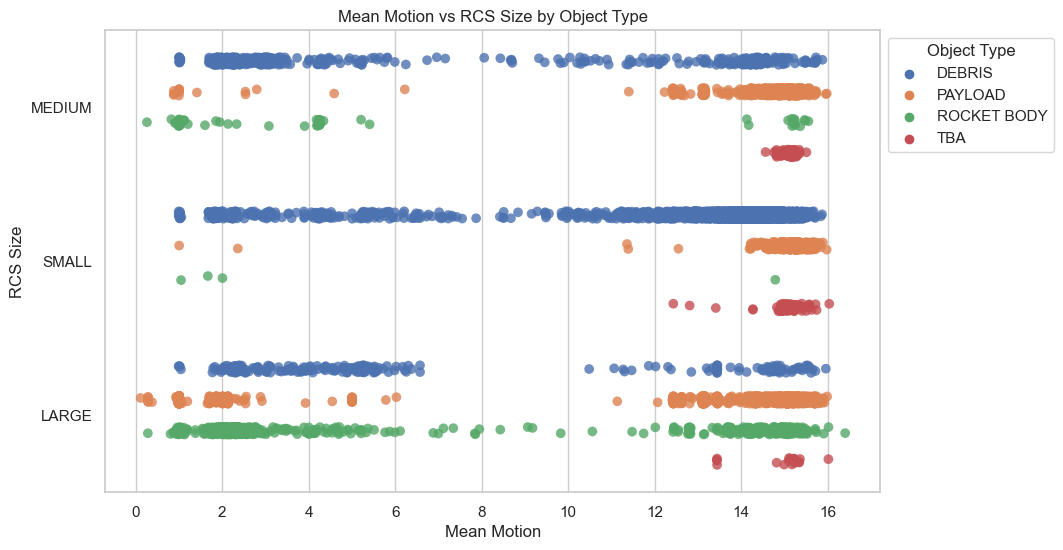

In [67]:
# *suppress FutureWarning messages due to deprecation warning
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# create the strip plot and style
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
sns.stripplot(data=close_orbit_df, x='MEAN_MOTION', y='RCS_SIZE', hue='OBJECT_TYPE', jitter=True, dodge=True, alpha=0.8, s=7)

# set plot title and labels
plt.title('Mean Motion vs RCS Size by Object Type')
plt.xlabel('Mean Motion')
plt.ylabel('RCS Size')

# show the legend
plt.legend(title='Object Type', bbox_to_anchor=(1, 1), loc='upper left')
plt.show()

# *return FutureWarning to default
warnings.simplefilter(action='default', category=FutureWarning)

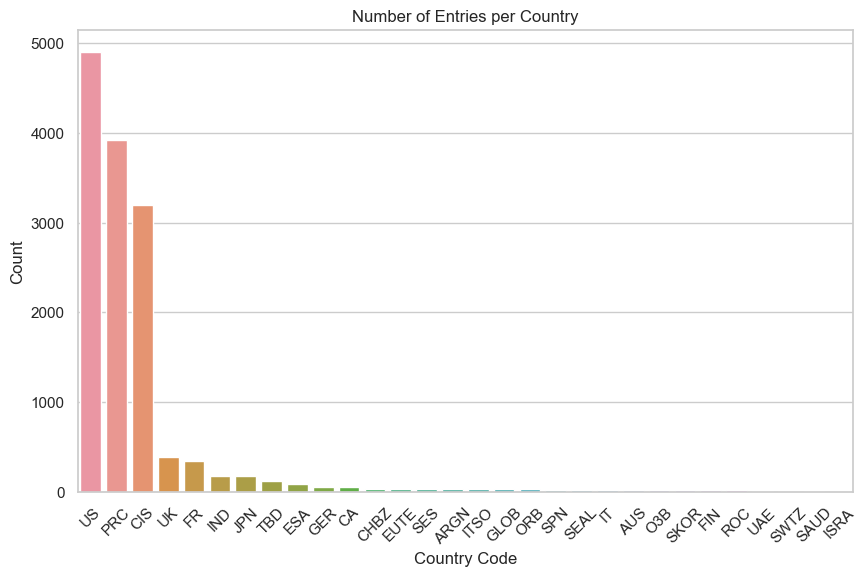

In [68]:
# count the countries and remove those with less than 10 occurances
country_counts = close_orbit_df['COUNTRY_CODE'].value_counts()
filtered_close_orbit_df = close_orbit_df[close_orbit_df['COUNTRY_CODE'].isin(country_counts[country_counts > 10].index)]

# bar plot to show the number of entries per country
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))

sns.countplot(data=filtered_close_orbit_df, x='COUNTRY_CODE', order=filtered_close_orbit_df['COUNTRY_CODE'].value_counts().index)
plt.title('Number of Entries per Country')
plt.xlabel('Country Code')
plt.xticks(rotation=45)  # rotate x-axis labels for better readability
plt.ylabel('Count')
plt.show()

In [51]:
# count the countries and remove those with more than 1000 occurances and less than 5
country_counts = close_orbit_df['COUNTRY_CODE'].value_counts()
filtered_close_orbit_df_ac = close_orbit_df[close_orbit_df['COUNTRY_CODE'].isin(country_counts[(country_counts > 5) & (country_counts < 100)].index)]

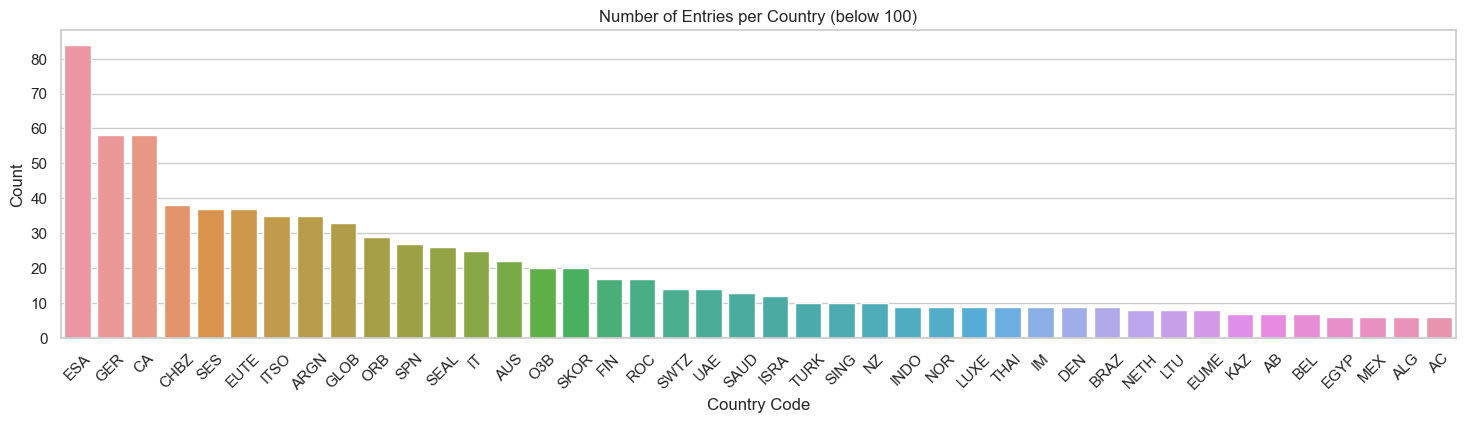

In [52]:
# bar plot to show the number of entries per country
sns.set(style="whitegrid")
plt.figure(figsize=(18, 4))

sns.countplot(data=filtered_close_orbit_df_ac, x='COUNTRY_CODE', order=filtered_close_orbit_df_ac['COUNTRY_CODE'].value_counts().index)
plt.title('Number of Entries per Country (below 100)')
plt.xlabel('Country Code')
plt.xticks(rotation=45)  # rotate x-axis labels for better readability
plt.ylabel('Count')
plt.show()

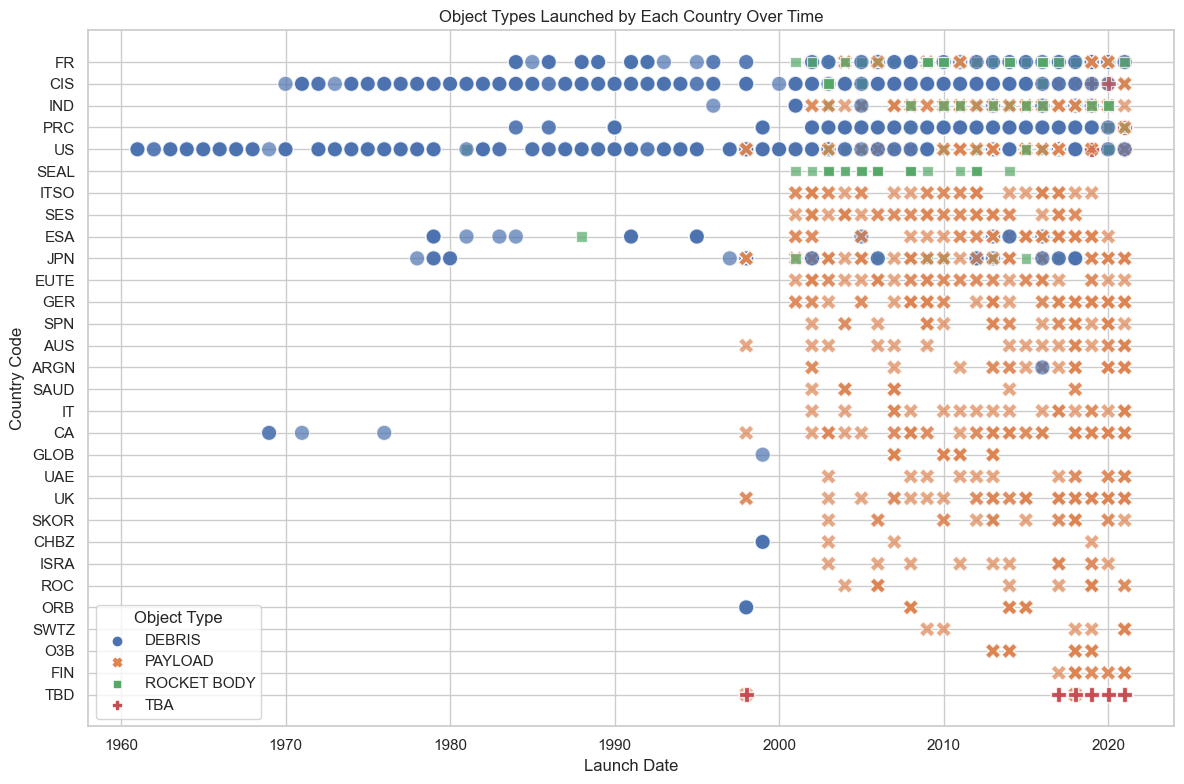

In [53]:
# Create plot
plt.figure(figsize=(12, 8))
sns.scatterplot(
    data=filtered_close_orbit_df,
    x='LAUNCH_DATE',
    y='COUNTRY_CODE',
    hue='OBJECT_TYPE',
    style='OBJECT_TYPE',
    s=120,
    alpha=0.7
)

# Enhance plot
plt.title('Object Types Launched by Each Country Over Time')
plt.xlabel('Launch Date')
plt.ylabel('Country Code')
plt.legend(title='Object Type')
plt.grid(True)

# Show plot
plt.tight_layout()
plt.show()

#### Model Training and Regression

An initial model training is performed on both datasets.

In [54]:
def tidy_dataset (df):
    '''Removes NaN and object types from dataset. Returns copy.'''
    objects_data = df.copy()
    objects_data = objects_data.dropna(axis=1)

    objects_data = remove_objects(objects_data)
    
    return objects_data

In [55]:
earth_close_orbit_data_tidy = tidy_dataset(earth_close_orbit_data)
y_l = earth_close_orbit_data_tidy['MEAN_MOTION']
earth_close_orbit_data_tidy.drop(columns=['MEAN_MOTION'])

,CCSDS_OMM_VERS,ECCENTRICITY,INCLINATION,RA_OF_ASC_NODE,ARG_OF_PERICENTER,MEAN_ANOMALY,EPHEMERIS_TYPE,NORAD_CAT_ID,ELEMENT_SET_NO,REV_AT_EPOCH,BSTAR,MEAN_MOTION_DOT,MEAN_MOTION_DDOT,SEMIMAJOR_AXIS,PERIOD,APOAPSIS,PERIAPSIS,FILE,GP_ID
0,2,0.65289,7.71560,90.24100,243.12160,38.77960,0,26741,999,23588,0.02434,0.00001,0.00000,"20,668.61800",492.86400,"27,784.87100",796.09500,3195178,188614016
1,2,0.00307,82.91930,299.11200,158.90930,201.33370,0,26743,999,50124,0.00007,0.00000,0.00000,"7,358.03800",104.68900,"1,002.50700",957.29900,3194950,188593285
2,2,0.02374,12.17170,16.53680,250.12480,146.29000,0,26745,999,7798,0.00000,-0.00000,0.00000,"41,197.85200","1,386.98400","35,797.69600","33,841.73800",3195026,188609573
3,2,0.00606,98.47810,8.72050,37.37710,323.16320,0,26754,999,10204,0.00032,0.00002,0.00000,"7,015.07600",97.45600,679.46500,594.41700,3194431,188556894
4,2,0.00623,98.42320,122.07240,345.16050,27.60610,0,26755,999,9622,0.00041,0.00003,0.00000,"7,031.40000",97.79600,697.03900,609.49100,3194950,188592541
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14367,2,0.00119,99.00980,214.68270,219.16130,140.87710,0,87970,999,37922,0.00681,0.00355,0.00000,"6,804.88200",93.10900,434.84400,418.65000,3191411,188414015
14368,2,0.00556,99.02720,141.11590,76.89260,283.84890,0,89171,999,32962,0.00178,0.00021,0.00000,"6,955.06600",96.20800,615.59900,538.26300,3194430,188550573
14369,2,0.05667,31.99160,262.93390,162.78240,199.28580,0,270007,999,9113,-0.00017,-0.00000,0.00000,"7,675.81700",111.54400,"1,732.69200",862.67200,3194431,188561362
14370,2,0.00582,98.67580,348.30680,187.02880,173.00810,0,270207,999,9893,0.00031,0.00001,0.00000,"7,188.20400",101.08600,851.91900,768.21900,3194431,188561387


In [56]:
model = LinearRegression()

In [57]:
model.fit(earth_close_orbit_data_tidy, y_l)

LinearRegression()

In [58]:
model.score(earth_close_orbit_data_tidy, y_l)

1.0

In [59]:
model.coef_

array([ 0.00000000e+00,  1.00000000e+00, -1.19265462e-11,  7.47224729e-16,
        1.85741553e-16, -1.41869904e-15,  6.68680157e-16,  5.30825384e-16,
        1.10513305e-16,  1.67921232e-15,  9.76003401e-19,  2.53211853e-13,
       -4.58802516e-11,  7.16270219e-10,  1.68262737e-12,  6.46628949e-15,
       -8.41477862e-13, -8.41798824e-13, -1.65500095e-15,  3.35647664e-17])

In [60]:
model.intercept_

-1.1775863839602607e-08

In [61]:
predictions = model.predict(earth_close_orbit_data_tidy)

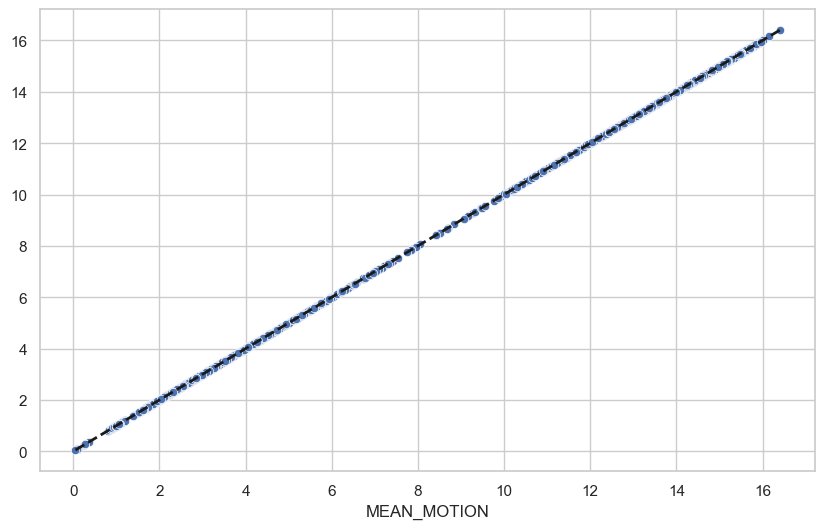

In [62]:
# Create a scatter plot to compare actual vs predicted values
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_l, y=predictions)

# Plot a diagonal line for reference (perfect prediction line)
plt.plot([y_l.min(), y_l.max()], [y_l.min(), y_l.max()], 'k--', lw=2)


C:\Users\zhech\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


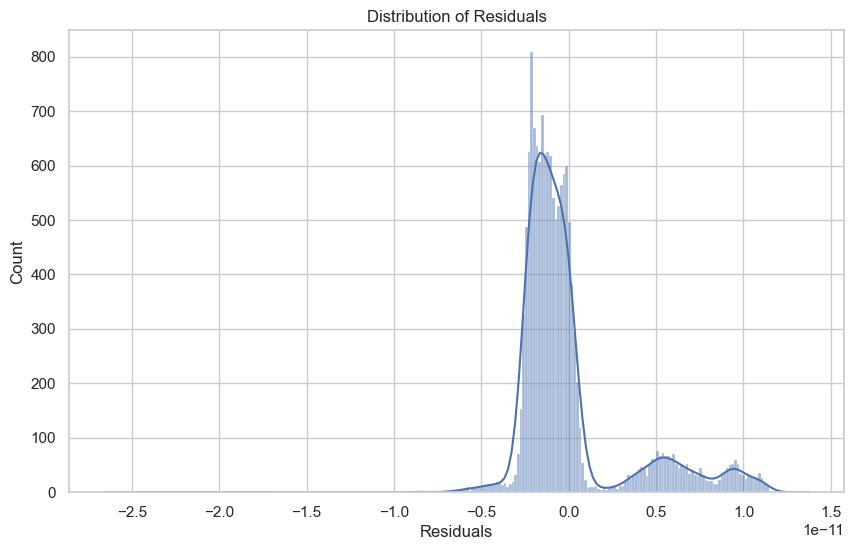

In [63]:
residuals = y_l - predictions

plt.figure(figsize=(10, 6))
sns.histplot(residuals, kde=True)
plt.xlabel('Residuals')
plt.title('Distribution of Residuals')
plt.show()

##### Perform training on our second datset:

In [137]:
model_data_e_o = pd.read_csv('./Datasets/space_decay.csv')

In [138]:
#model_data_e_o = model_data_e_o.tail(8000)
model_data_e_o.drop(columns='DECAY_DATE')

,CCSDS_OMM_VERS,COMMENT,CREATION_DATE,ORIGINATOR,OBJECT_NAME,OBJECT_ID,CENTER_NAME,REF_FRAME,TIME_SYSTEM,MEAN_ELEMENT_THEORY,...,OBJECT_TYPE,RCS_SIZE,COUNTRY_CODE,LAUNCH_DATE,SITE,FILE,GP_ID,TLE_LINE0,TLE_LINE1,TLE_LINE2
0,2,GENERATED VIA SPACE-TRACK.ORG API,2021-11-01T06:46:11,18 SPCS,ARIANE 42P+ DEB,1992-072J,EARTH,TEME,UTC,SGP4,...,DEBRIS,MEDIUM,FR,"1,992.00000",FRGUI,3195178,188614016,0 ARIANE 42P+ DEB,1 26741U 92072J 21304.94919376 .00000883 0...,2 26741 7.7156 90.2410 6528926 243.1216 38...
1,2,GENERATED VIA SPACE-TRACK.ORG API,2021-11-01T04:58:37,18 SPCS,SL-8 DEB,1979-028C,EARTH,TEME,UTC,SGP4,...,DEBRIS,SMALL,CIS,"1,979.00000",PKMTR,3194950,188593285,0 SL-8 DEB,1 26743U 79028C 21304.68908982 .00000079 0...,2 26743 82.9193 299.1120 0030720 158.9093 201...
2,2,GENERATED VIA SPACE-TRACK.ORG API,2021-11-01T06:26:11,18 SPCS,GSAT 1,2001-015A,EARTH,TEME,UTC,SGP4,...,PAYLOAD,LARGE,IND,"2,001.00000",SRI,3195026,188609573,0 GSAT 1,1 26745U 01015A 21305.22411368 -.00000165 0...,2 26745 12.1717 16.5368 0237386 250.1248 146...
3,2,GENERATED VIA SPACE-TRACK.ORG API,2021-10-31T18:07:15,18 SPCS,CZ-4 DEB,1999-057MB,EARTH,TEME,UTC,SGP4,...,DEBRIS,SMALL,PRC,"1,999.00000",TSC,3194431,188556894,0 CZ-4 DEB,1 26754U 99057MB 21304.46625230 .00002265 0...,2 26754 98.4781 8.7205 0060618 37.3771 323...
4,2,GENERATED VIA SPACE-TRACK.ORG API,2021-11-01T04:58:37,18 SPCS,CZ-4 DEB,1999-057MC,EARTH,TEME,UTC,SGP4,...,DEBRIS,SMALL,PRC,"1,999.00000",TSC,3194950,188592541,0 CZ-4 DEB,1 26755U 99057MC 21304.74081807 .00002610 0...,2 26755 98.4232 122.0724 0062255 345.1605 27...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14367,2,GENERATED VIA SPACE-TRACK.ORG API,2021-10-29T18:22:04,18 SPCS,TBA - TO BE ASSIGNED,NaN,EARTH,TEME,UTC,SGP4,...,TBA,NaN,NaN,NaN,NaN,3191411,188414015,0 TBA - TO BE ASSIGNED,1 87970U 21285.56271139 +.00354808 +0...,2 87970 99.0098 214.6827 0011899 219.1613 140...
14368,2,GENERATED VIA SPACE-TRACK.ORG API,2021-10-31T18:06:35,18 SPCS,TBA - TO BE ASSIGNED,NaN,EARTH,TEME,UTC,SGP4,...,TBA,NaN,NaN,NaN,NaN,3194430,188550573,0 TBA - TO BE ASSIGNED,1 89171U 21304.27943186 +.00020950 +0...,2 89171 99.0272 141.1159 0055597 76.8926 283...
14369,2,GENERATED VIA SPACE-TRACK.ORG API,2021-10-31T18:07:15,18 SPCS,TBA - TO BE ASSIGNED,NaN,EARTH,TEME,UTC,SGP4,...,TBA,NaN,NaN,NaN,NaN,3194431,188561362,0 TBA - TO BE ASSIGNED,1 T0007U 21304.15669309 -.00000068 0...,2 T0007 31.9916 262.9339 0566728 162.7824 199...
14370,2,GENERATED VIA SPACE-TRACK.ORG API,2021-10-31T18:07:15,18 SPCS,TBA - TO BE ASSIGNED,NaN,EARTH,TEME,UTC,SGP4,...,TBA,NaN,NaN,NaN,NaN,3194431,188561387,0 TBA - TO BE ASSIGNED,1 T0207U 21304.37554955 .00000690 0...,2 T0207 98.6758 348.3068 0058220 187.0288 173...


In [139]:
model_data_e_o.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14372 entries, 0 to 14371
Data columns (total 40 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   CCSDS_OMM_VERS       14372 non-null  int64  
 1   COMMENT              14372 non-null  object 
 2   CREATION_DATE        14372 non-null  object 
 3   ORIGINATOR           14372 non-null  object 
 4   OBJECT_NAME          14372 non-null  object 
 5   OBJECT_ID            14333 non-null  object 
 6   CENTER_NAME          14372 non-null  object 
 7   REF_FRAME            14372 non-null  object 
 8   TIME_SYSTEM          14372 non-null  object 
 9   MEAN_ELEMENT_THEORY  14372 non-null  object 
 10  EPOCH                14372 non-null  object 
 11  MEAN_MOTION          14372 non-null  float64
 12  ECCENTRICITY         14372 non-null  float64
 13  INCLINATION          14372 non-null  float64
 14  RA_OF_ASC_NODE       14372 non-null  float64
 15  ARG_OF_PERICENTER    14372 non-null 

In [149]:
# remove rows with NaN values
model_data_e_o = model_data_e_o.dropna(subset=['LAUNCH_DATE'])
# replace inf values with a specific value, e.g., the maximum value in the column
model_data_e_o['LAUNCH_DATE'] = model_data_e_o['LAUNCH_DATE'].replace(np.inf, model_data_e_o['LAUNCH_DATE'][model_data_e_o['LAUNCH_DATE'] != np.inf].max())

# Identify and handle unrealistic values (e.g., values > 2100)
model_data_e_o = model_data_e_o[model_data_e_o['LAUNCH_DATE'] <= 2100]

# convert to integer and then to datetime
# model_data_e_o['LAUNCH_DATE'] = pd.to_datetime(model_data_e_o['LAUNCH_DATE'].astype('int64'), format='%Y')
# ensure LAUNCH_DATE is properly converted to datetime
objects_per_year['LAUNCH_DATE'] = pd.to_datetime(objects_per_year['LAUNCH_DATE'])


In [150]:
# label encode categorical features like 'OBJECT_NAME', 'COUNTRY_CODE', 'RCS_SIZE'
label_encoders = {}
for column in ['OBJECT_NAME', 'COUNTRY_CODE', 'RCS_SIZE']:
    le = LabelEncoder()
    model_data_e_o[column] = le.fit_transform(model_data_e_o[column].astype(str))
    label_encoders[column] = le

# for regression: Predict number of objects per year
objects_per_year = model_data_e_o.groupby('LAUNCH_DATE').size().reset_index(name='count')

# split the data
X_reg = objects_per_year[['LAUNCH_DATE']]
y_reg = objects_per_year['count']

In [151]:
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(X_reg, y_reg, test_size=0.2, random_state=42)

# train a regression model
reg_model = LinearRegression()
reg_model.fit(X_train_reg, y_train_reg)

LinearRegression()

In [152]:
# predict future object counts
future_years = pd.DataFrame({'LAUNCH_DATE': range(2020, 2051)})
future_predictions = reg_model.predict(future_years)

In [153]:
# for classification: Predict object type
X_class = model_data_e_o[['LAUNCH_DATE', 'COUNTRY_CODE', 'RCS_SIZE']]
y_class = model_data_e_o['OBJECT_NAME']

In [154]:
# convert datetime64 column to numeric (e.g., number of days since the UNIX epoch)
X_class.loc[:, 'LAUNCH_DATE'] = X_class['LAUNCH_DATE'].view('int64')
X_train_class, X_test_class, y_train_class, y_test_class = train_test_split(X_class, y_class, test_size=0.2, random_state=42)

In [155]:
# train a classification model
class_model = LogisticRegression(max_iter=3000, solver='saga', C=1.0)
class_model.fit(X_train_class, y_train_class)

LogisticRegression(max_iter=3000, solver='saga')

In [156]:
# predict object types
object_type_predictions = class_model.predict(X_test_class)

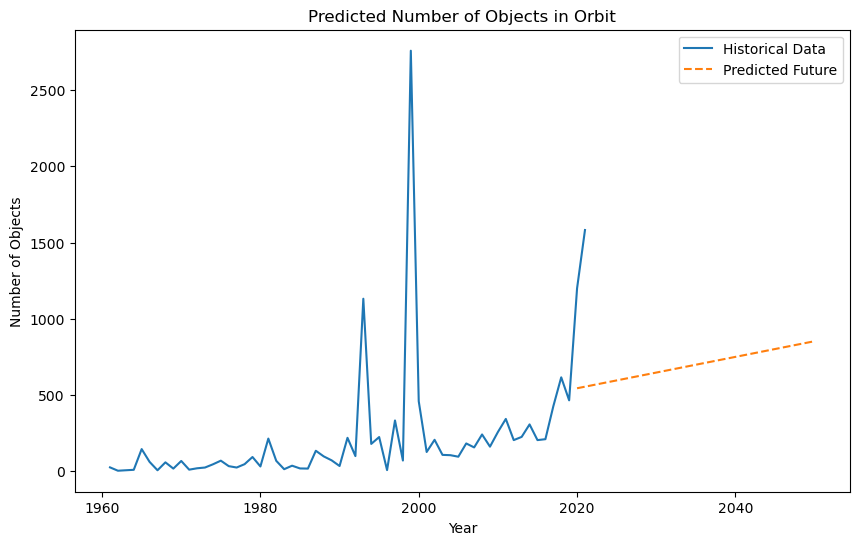

In [157]:
# plotting future predictions
plt.figure(figsize=(10, 6))
plt.plot(objects_per_year['LAUNCH_DATE'], objects_per_year['count'], label='Historical Data')
plt.plot(future_years['LAUNCH_DATE'], future_predictions, label='Predicted Future', linestyle='--')
plt.xlabel('Year')
plt.ylabel('Number of Objects')
plt.title('Predicted Number of Objects in Orbit')
plt.legend()
plt.show()

In [158]:
print(objects_per_year.head())
print(objects_per_year.describe())

   LAUNCH_DATE  count
0  1,961.00000     24
1  1,962.00000      2
2  1,963.00000      5
3  1,964.00000      8
4  1,965.00000    144
       LAUNCH_DATE       count
count     61.00000    61.00000
mean   1,991.00000   234.96721
std       17.75293   438.18151
min    1,961.00000     2.00000
25%    1,976.00000    32.00000
50%    1,991.00000    98.00000
75%    2,006.00000   218.00000
max    2,021.00000 2,759.00000
